Yaml Model  model-tp5 .yaml loaded 
Weights  model-tp5 .h5 loaded 
image name=240696675_7d05193aa0.jpg caption=<start> The man and lady pose for a picture . <end>


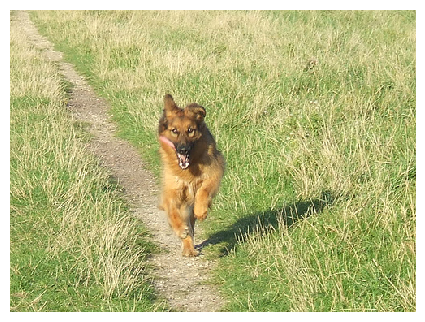

Caption n° 1: two young girls in a blue shirt and blue jeans and a red shirt and blue jeans is running on a sidewalk . <end> 
Caption n° 2: two young girls in a blue shirt and blue jeans and a red shirt and blue jeans and a black and white dog is running through the grass . <end> 
Caption n° 3: two young girls are standing on a sidewalk . <end> 
Caption n° 4: two young girls are standing on a sidewalk . <end> 
Caption n° 5: a man in a blue shirt is standing in front of a large white dog . <end> 


In [2]:
from keras.models import model_from_yaml
from keras.layers.recurrent import SimpleRNN
from keras.models import Sequential
from keras.layers import Dense, Activation, Masking
import matplotlib.image as mpimg
import pandas as pd
import _pickle as pickle
from keras.models import model_from_yaml
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

maxLCap = 35
nbkeep = 1000


def loadModel(savename):
    with open(savename + ".yaml", "r") as yaml_file:
        model = model_from_yaml(yaml_file.read())
    print("Yaml Model ", savename, ".yaml loaded ")
    model.load_weights(savename + ".h5")
    print("Weights ", savename, ".h5 loaded ")
    return model


def sampling(preds, temperature=0.1):
    preds = np.asarray(preds).astype('float64')
    predsN = pow(preds, 1.0 / temperature)
    predsN /= np.sum(predsN)
    probas = np.random.multinomial(1, predsN, 1)
    return np.argmax(probas)


# LOADING MODEL
nameModel = 'model-projet_setsis'
model = loadModel(nameModel)

optim = Adam()
model.compile(loss="categorical_crossentropy", optimizer=optim, metrics=['accuracy'])

# LOADING TEST DATA
outfile = 'Testing_data_' + str(nbkeep) + '.npz'
npzfile = np.load(outfile)

X_test = npzfile['X_test']
Y_test = npzfile['Y_test']

outfile = "Caption_Embeddings_" + str(nbkeep) + ".p"
[listwords, embeddings] = pickle.load(open(outfile, "rb"))
indexwords = {}
for i in range(len(listwords)):
    indexwords[listwords[i]] = i

ind = np.random.randint(X_test.shape[0])

filename = 'flickr_8k_test_dataset.txt'  # PATH IF NEEDED

df = pd.read_csv(filename, delimiter='\t')
iter = df.iterrows()

for i in range(ind + 1):
    x = iter.__next__()

imname = "240696675_7d05193aa0.jpg"
print("image name=" + imname + " caption=" + x[1][1])


img = mpimg.imread(imname)
plt.figure(dpi=100)
plt.imshow(img)
plt.axis('off')
plt.show()

pred = model.predict(X_test[ind:ind + 1, :, :])

nbGen = 5
temperature = 0.1  # Temperature param for peacking soft-max distribution

for s in range(nbGen):
    wordpreds = "Caption n° " + str(s + 1) + ": "
    indpred = sampling(pred[0, 0, :], temperature)
    wordpred = listwords[indpred]
    wordpreds += str(wordpred) + " "
    X_test[ind:ind + 1, 1, 0:102] = embeddings[listwords.index(wordpred)] 
    cpt = 1
    while (str(wordpred) != '<end>' and cpt < 30):
        pred = model.predict(X_test[ind:ind + 1, :, :])
        indpred = sampling(pred[0, cpt, :], temperature)
        wordpred = listwords[indpred]
        wordpreds += str(wordpred) + " "
        cpt += 1
        X_test[ind:ind + 1, cpt, 0:102] = embeddings[listwords.index(wordpred)] 

    print(wordpreds)